<a href="https://colab.research.google.com/github/Praveengovianalytics/50DaysofRecomSystem/blob/main/Day_14_Collabrative_Filtering_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 14 - Agenda

Business Case :- 

A Book store currently having a website , List of book items in the website is static ,book store recommend its books to customers in random way. 

Books Store want to create the personalised shopping experience to its customers based on the existing shopping history from its data lake

Benefit case :- 

*   Personalised shopping experiance to Customers 
*   Retaining Customers or Avoid Customers Churn
*   Improve the sales marigin

# Part 1 - 

We are using a neural network approach to building a collaborative filtering recommender system. Let understand the interation between Customer  Users with Books list      


In [1]:
from google.colab import drive
#drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


Data link :- 

Download the data in below link 

[link text](https://www.kaggle.com/zygmunt/goodbooks-10k)

In [35]:
Data_path="gdrive/MyDrive/Colab Notebooks/50_Days_of_Recommendation_Systems/Datasets/book_recommendation_dataset/"
model_name="gdrive/MyDrive/Colab Notebooks/50_Days_of_Recommendation_Systems/models/Day_14_nncoll_model"
embed_path="gdrive/MyDrive/Colab Notebooks/50_Days_of_Recommendation_Systems/embeddings/"

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow.keras as tf

In [13]:
ratings_df = pd.read_csv(Data_path+"/ratings.csv") 
books_df = pd.read_csv(Data_path+"/books.csv")
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [14]:
def missing_data_pct(df):
    # checking missing data
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
    missing_df  = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
    return missing_df

In [15]:
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [16]:
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [17]:
print('Total ratings given by users :-',ratings_df.shape[0])
print('Total unique users :-',ratings_df.user_id.nunique())
print('Total unique books :-',ratings_df.book_id.nunique())

Total ratings given by users :- 981756
Total unique users :- 53424
Total unique books :- 10000


In [18]:
missing_data_pct(ratings_df)

,Total,Missing Percent
rating,0,0.0
user_id,0,0.0
book_id,0,0.0


In [19]:
missing_data_pct(books_df)

,Total,Missing Percent
language_code,1084,10.84
isbn,700,7.00
isbn13,585,5.85
original_title,585,5.85
original_publication_year,21,0.21
title,0,0.00
book_id,0,0.00
best_book_id,0,0.00
work_id,0,0.00
books_count,0,0.00


In [20]:
from sklearn.model_selection import train_test_split

In [21]:
Xtrain, Xtest = train_test_split(ratings_df, test_size=0.2, random_state=1)

In [22]:
print(f"Shape of train data:- {Xtrain.shape}")
print(f"Shape of test data :- {Xtest.shape}")

Shape of train data:- (785404, 3)
Shape of test data :- (196352, 3)


# Building the recommendation engine using TensorFlow / Keras

The neural network we’re going to create will have two input embedding layers. The first embedding layer accepts the books, and the second the users. These two embeddings are trained separately and then combined together before being passed to a dense layer.



Books Embedding layer + User embedding layer => Concatenate togather => Dense layer => Output 
**bold text**

In [23]:
nbook_id = ratings_df.book_id.nunique()
nuser_id = ratings_df.user_id.nunique()

In [24]:

#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [25]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [26]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=3, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/3
12272/12272 [==============================] - 175s 14ms/step - loss: 1.3281 - val_loss: 0.7135
Epoch 2/3
12272/12272 [==============================] - 165s 13ms/step - loss: 0.6763 - val_loss: 0.6987
Epoch 3/3
12272/12272 [==============================] - 179s 15ms/step - loss: 0.6378 - val_loss: 0.6935


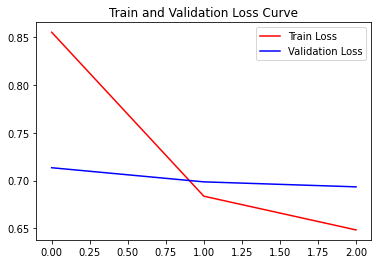

In [27]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [32]:
#save the model
model.save(model_name)

INFO:tensorflow:Assets written to: gdrive/MyDrive/Colab Notebooks/50_Days_of_Recommendation_Systems/models/Day_14_nncoll_model/assets


# Lets visualise the embeddings in higher dimentions

In [33]:
# Extract embeddings
book_em = model.get_layer('embedding')
book_em_weights = book_em.get_weights()[0]
book_em_weights.shape

(10001, 15)

In [34]:
books_df_copy = books_df.copy()
books_df_copy = books_df_copy.set_index("book_id")

In [36]:
b_id =list(ratings_df.book_id.unique())
b_id.remove(10000)
dict_map = {}
for i in b_id:
    dict_map[i] = books_df_copy.iloc[i]['title']
    
out_v = open(embed_path+'vecs.tsv', 'w')
out_m = open(embed_path+'meta.tsv', 'w')
for i in b_id:
    book = dict_map[i]
    embeddings = book_em_weights[i]
    out_m.write(book + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

[Tensorboard for embedding visualisation](http://projector.tensorflow.org/)


Two tsv files—one containing the embedding weights, and the other containing the corresponding book title.

Confirm you have the two tsv files in your directory. If so, go to the TensorFlow Embedding Projector page, wait for the default embedding to load, and then click Load to upload your tsv files.



# Part 2 - We will deploy the recommendation model with bookshopping to get real feel of recommendation model in action